# Semantic Segmentation for Autonomous Vehicles

## Importing Libraries

In [2]:
import tensorflow as tf
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import os
from PIL import Image
import cv2
from tensorflow.keras.preprocessing.image import load_img,array_to_img,img_to_array
from tensorflow.keras import layers
import skimage
import keras
import tensorboard
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import *
import random
import skimage
from tensorflow.keras.callbacks import EarlyStopping
import imageio
from keras.utils.vis_utils import plot_model
from IPython.display import Image

## Preprocessing

In [3]:
rgb_dir=r'/content/drive/MyDrive/Colab Notebooks/dataD/dataD/CameraRGB'
seg_dir=r'/content/drive/MyDrive/Colab Notebooks/dataD/dataD/CameraSeg'
images_path = list(sorted([ os.path.join(rgb_dir, fname) for fname in os.listdir(rgb_dir) ]))
segmentations_path = list(sorted([ os.path.join(seg_dir, fname) for fname in os.listdir(seg_dir)]))

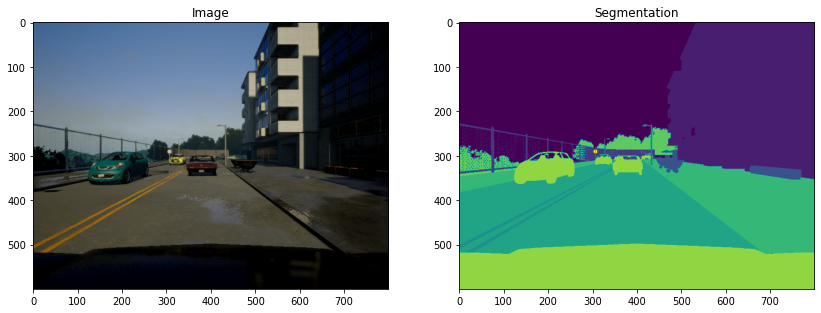

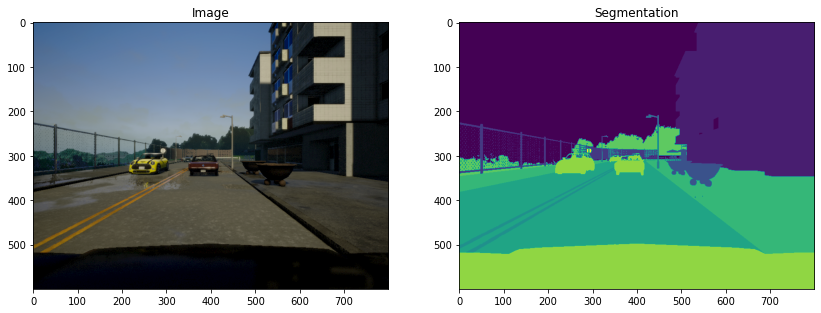

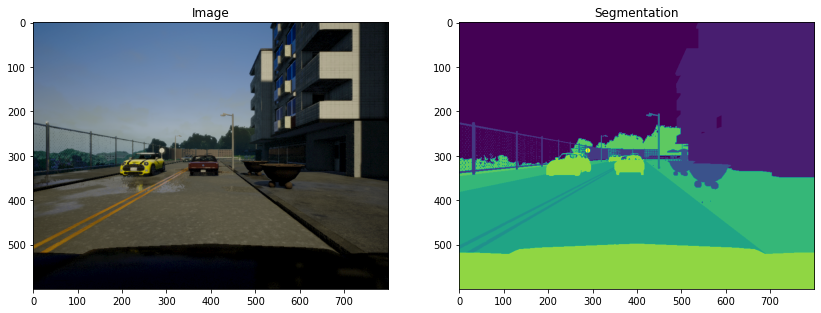

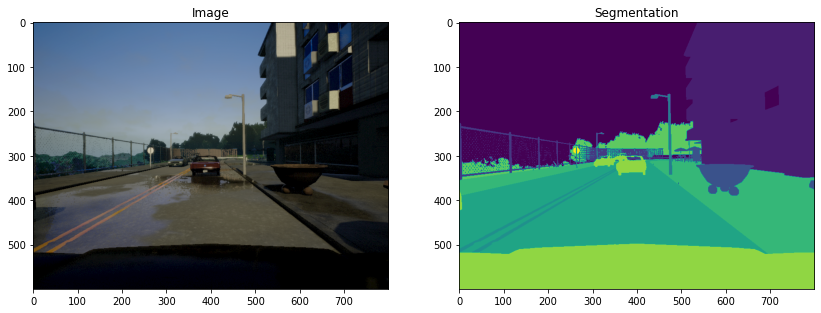

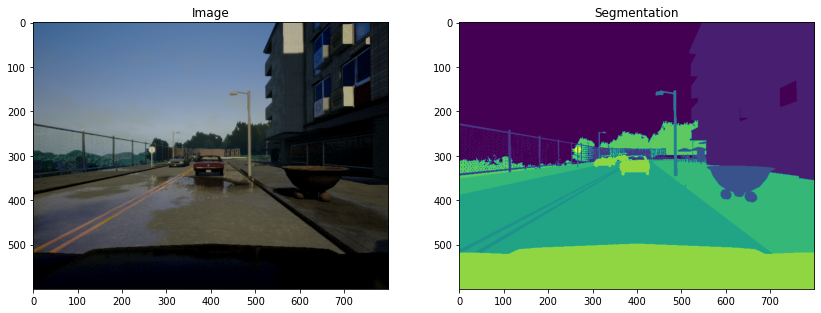

In [4]:
for N in range(95,100):
    img = imageio.imread(images_path[N])
    mask = imageio.imread(segmentations_path[N])
    mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

    fig, arr = plt.subplots(1, 2, figsize=(14, 10))
    arr[0].imshow(img)
    arr[0].set_title('Image')
    arr[1].imshow(mask)
    arr[1].set_title('Segmentation')

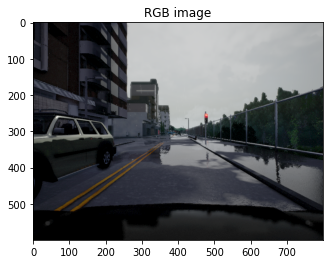

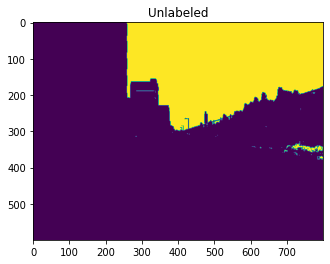

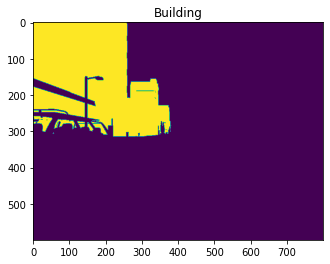

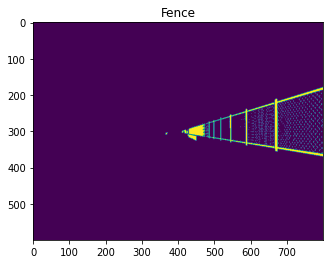

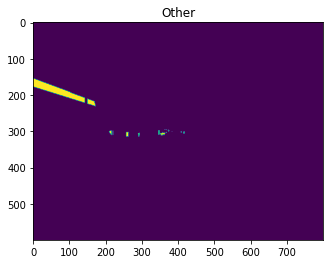

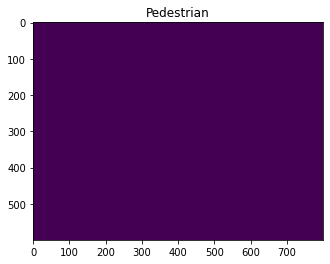

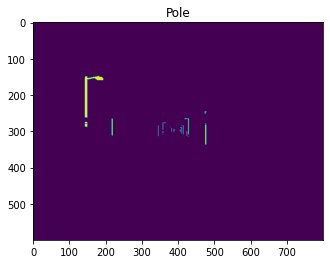

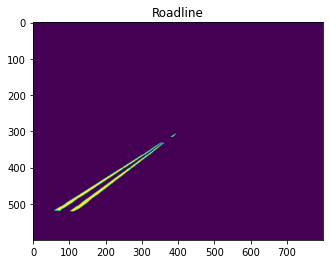

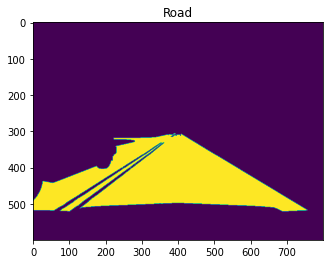

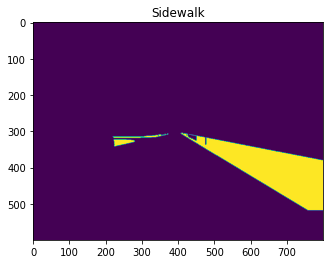

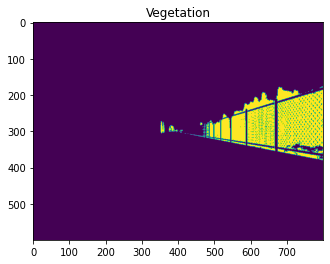

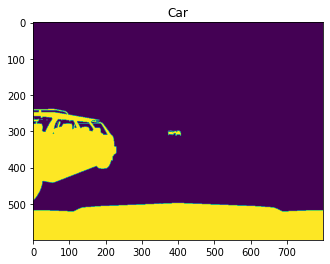

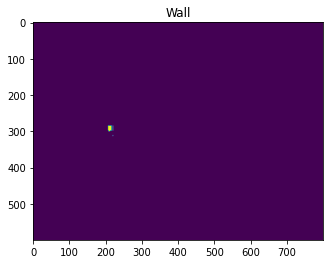

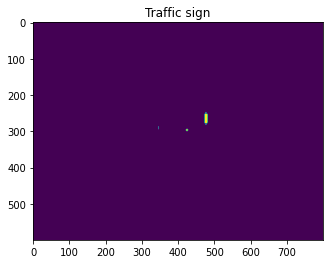

In [5]:
plt.figure()
plt.imshow(plt.imread('/content/drive/MyDrive/Colab Notebooks/dataD/dataD/CameraRGB/02_00_006.png'))
plt.title('RGB image')
plt.show()
#subplot(r,c) provide the no. of rows and columns
#f, axarr = plt.subplots(1,13,figsize=(15,12)) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically

labels = ['Unlabeled','Building','Fence','Other',
                 'Pedestrian', 'Pole', 'Roadline', 'Road',
                 'Sidewalk', 'Vegetation', 'Car','Wall',
                 'Traffic sign']

for i in range(13):
    mask = plt.imread('/content/drive/MyDrive/Colab Notebooks/dataD/dataD/CameraSeg/02_00_006.png')*255
    mask = np.where(mask == i, 255, 0)
    mask = mask[:,:,0]
    #axarr[i].imshow(mask)
    plt.title(labels[i])
    plt.imshow(mask)
    plt.show()

In [6]:
images=[]
annotations=[]
for i in range(1000):
    img1,mask1= cv2.imread(images_path[i]),cv2.imread(segmentations_path[i])[:,:,2]
    img1=cv2.resize(img1,(256,256)) 
    mask1=cv2.resize(mask1,(256,256))
    images.append(img1)
    annotations.append(mask1)
images=np.array(images)
annotations=np.array(annotations)

In [7]:
img_h, img_w= 256, 256
num_classes= 13

## Problem Modelling

In [8]:
def AtrousSpatialPyramidPooling(model_input):
    dims = tf.keras.backend.int_shape(model_input)
    
    layer = tf.keras.layers.AveragePooling2D(pool_size=(dims[-3],
                                                      dims[-2]))(model_input)
    layer = tf.keras.layers.Conv2D(256, kernel_size=1, padding='same',
                                 kernel_initializer = 'he_normal')(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.ReLU()(layer)
    out_pool = tf.keras.layers.UpSampling2D(size = (dims[-3] // layer.shape[1],
                                               dims[-2] // layer.shape[2]),
                                        interpolation = 'bilinear')(layer)
    layer = tf.keras.layers.Conv2D(256, kernel_size = 1,
                                   dilation_rate = 1, padding = 'same',
                                   kernel_initializer = 'he_normal',
                                   use_bias = False)(model_input)
    layer = tf.keras.layers.BatchNormalization()(layer)
    out_1 = tf.keras.layers.ReLU()(layer)
    
    layer = tf.keras.layers.Conv2D(256, kernel_size = 3,
                                   dilation_rate = 6, padding = 'same', 
                                   kernel_initializer = 'he_normal',
                                   use_bias = False)(model_input)
    layer = tf.keras.layers.BatchNormalization()(layer)
    out_6 = tf.keras.layers.ReLU()(layer)
    
    layer = tf.keras.layers.Conv2D(256, kernel_size = 3,
                                   dilation_rate = 12, padding = 'same',
                                   kernel_initializer = 'he_normal',
                                   use_bias = False)(model_input)
    layer = tf.keras.layers.BatchNormalization()(layer)
    out_12 = tf.keras.layers.ReLU()(layer)

    layer = tf.keras.layers.Conv2D(256, kernel_size = 3,
                                   dilation_rate = 18, padding = 'same',
                                   kernel_initializer = 'he_normal',
                                   use_bias = False)(model_input)
    layer = tf.keras.layers.BatchNormalization()(layer)
    out_18 = tf.keras.layers.ReLU()(layer)

    layer = tf.keras.layers.Concatenate(axis = -1)([out_pool, out_1,
                                                    out_6, out_12,
                                                    out_18])
    layer = tf.keras.layers.Conv2D(256, kernel_size = 1,
                                   dilation_rate = 1, padding = 'same',
                                   kernel_initializer = 'he_normal',
                                   use_bias = False)(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    model_output = tf.keras.layers.ReLU()(layer)
    return model_output

In [9]:
def DeeplabV3Plus():
    model_input = tf.keras.Input(shape= (img_h,img_w,3))
    resnet50 = tf.keras.applications.ResNet50(weights = 'imagenet',
                                            include_top = False,
                                            input_tensor = model_input)
    layer = resnet50.get_layer('conv4_block6_2_relu').output
    layer = AtrousSpatialPyramidPooling(layer)
    input_a = tf.keras.layers.UpSampling2D(size = (img_h // 4 // layer.shape[1],
                                                 img_w // 4 // layer.shape[2]),
                                          interpolation = 'bilinear')(layer)
    input_b = resnet50.get_layer('conv2_block3_2_relu').output
    input_b = tf.keras.layers.Conv2D(48, kernel_size = (1,1), padding = 'same',
                                   kernel_initializer = tf.keras.initializers.he_normal(),
                                   use_bias = False)(input_b)
    input_b = tf.keras.layers.BatchNormalization()(input_b)
    input_b = tf.keras.layers.ReLU()(input_b)
    
    layer = tf.keras.layers.Concatenate(axis = -1)([input_a, input_b])
    layer = tf.keras.layers.Conv2D(256, kernel_size = 3,
                                   padding = 'same', activation = 'relu',
                                   kernel_initializer = tf.keras.initializers.he_normal(),
                                   use_bias = False)(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.ReLU()(layer)
    layer = tf.keras.layers.Conv2D(256, kernel_size =3,
                                   padding = 'same', activation = 'relu',
                                   kernel_initializer = tf.keras.initializers.he_normal(),
                                   use_bias = False)(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.ReLU()(layer)
    layer = tf.keras.layers.UpSampling2D(size = (img_h // layer.shape[1],
                                                 img_w // layer.shape[2]),
                                          interpolation = 'bilinear')(layer)
    model_output = tf.keras.layers.Conv2D(num_classes, kernel_size = (1,1),
                                   padding = 'same')(layer)
    return tf.keras.Model(inputs = model_input, outputs = model_output)

In [10]:
keras.backend.clear_session()
model = DeeplabV3Plus()
model.summary()
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics='accuracy')
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/DEEP LAB MODEL/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=False)

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_____________________________

In [11]:
model.load_weights(r'/content/drive/MyDrive/Colab Notebooks/DEEP LAB MODEL/cp-0005.ckpt')
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)

In [12]:
%%time
model.fit(images,annotations,batch_size=32, epochs = 100,validation_split=0.2, callbacks= [early_stop])

Epoch 1/100
25/25 [==============================] - 68s 916ms/step - loss: 0.5186 - accuracy: 0.8692 - val_loss: 0.6001 - val_accuracy: 0.8554
Epoch 2/100
25/25 [==============================] - 21s 832ms/step - loss: 0.4946 - accuracy: 0.8553 - val_loss: 0.7201 - val_accuracy: 0.8432
Epoch 3/100
25/25 [==============================] - 21s 859ms/step - loss: 0.6008 - accuracy: 0.8313 - val_loss: 11.5326 - val_accuracy: 0.2269
Epoch 4/100
25/25 [==============================] - 22s 884ms/step - loss: 0.7218 - accuracy: 0.7436 - val_loss: 11.8913 - val_accuracy: 0.2087
Epoch 5/100
25/25 [==============================] - 22s 863ms/step - loss: 0.6075 - accuracy: 0.7959 - val_loss: 5.2416 - val_accuracy: 0.4125
Epoch 6/100
25/25 [==============================] - 21s 854ms/step - loss: 0.5515 - accuracy: 0.8304 - val_loss: 1.2077 - val_accuracy: 0.7631
Epoch 7/100
25/25 [==============================] - 22s 864ms/step - loss: 0.5677 - accuracy: 0.8443 - val_loss: 9.4978 - val_accurac

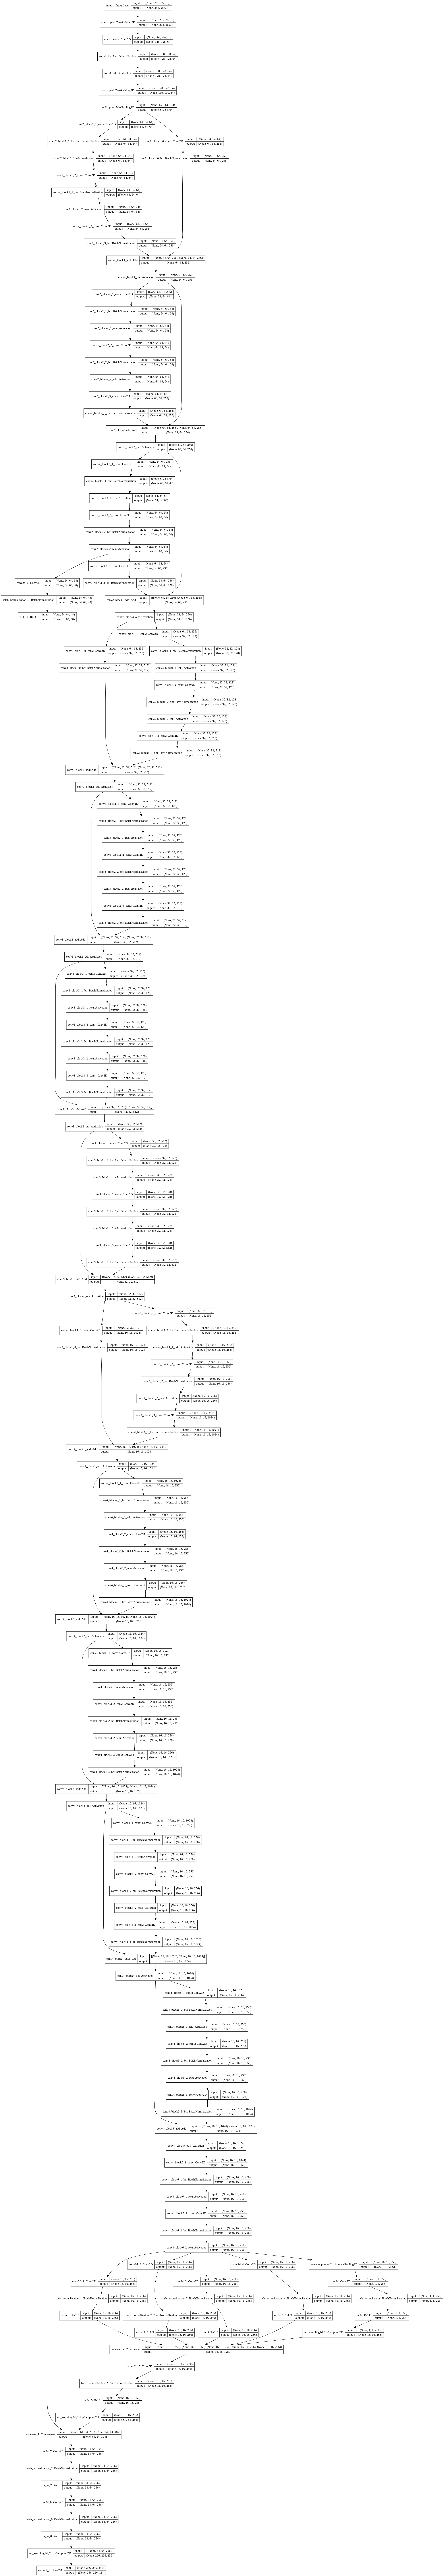

In [13]:
plot_model(model,to_file='/content/drive/MyDrive/Colab Notebooks/DEEP LAB MODEL/deeplabplus.png',show_shapes=True, show_layer_names=True)
Image(retina=True, filename='/content/drive/MyDrive/Colab Notebooks/DEEP LAB MODEL/deeplabplus.png')

In [14]:
model_loss = pd.DataFrame(model.history.history)
model_loss

loss  accuracy   val_loss  val_accuracy
0   0.527265  0.861476   0.600095      0.855437
1   0.508099  0.859338   0.720073      0.843226
2   0.708255  0.780478  11.532616      0.226933
3   0.696219  0.756239  11.891283      0.208700
4   0.597187  0.803204   5.241587      0.412519
..       ...       ...        ...           ...
95  0.318361  0.907737   0.374274      0.902948
96  0.348884  0.905901   0.429917      0.895073
97  0.344326  0.904268   0.415133      0.893493
98  0.318696  0.910798   0.383503      0.902408
99  0.318460  0.910189   0.463669      0.882955

[100 rows x 4 columns]

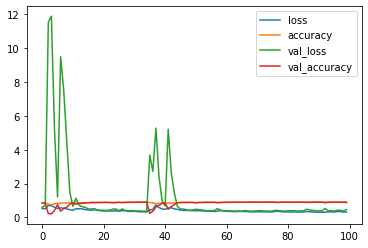

In [15]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

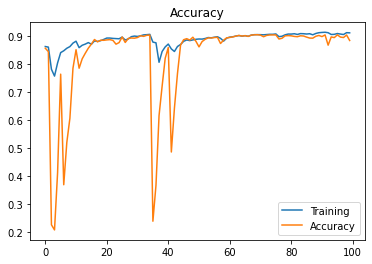

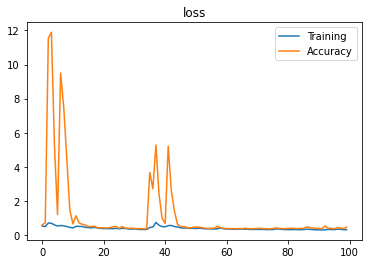

In [16]:
plt.figure()
plt.plot(model.history.history['accuracy'], label = 'Training')
plt.plot(model.history.history['val_accuracy'], label = 'Validation')
plt.title('Accuracy')
plt.legend()

plt.figure()
plt.plot(model.history.history['loss'], label = 'Training')
plt.plot(model.history.history['val_loss'], label = 'Validation')
plt.title('loss')
plt.legend()

In [17]:
def plotter(img,mask):
    fig,axes=plt.subplots(1,2)
    axes[0].imshow(img)
    plt.imshow(mask)

## Model Prediction and Evaluation

(1, 256, 256, 13)
[[[[-7.7662636e-03  4.6817890e-01 -9.0157427e-03 ...  5.1943064e-03
    -1.2625749e-01 -3.5263926e-02]
   [-7.7662636e-03  4.6817890e-01 -9.0157427e-03 ...  5.1943064e-03
    -1.2625749e-01 -3.5263926e-02]
   [-1.3387473e-02  5.1236188e-01 -1.7390275e-02 ... -1.9273381e-03
    -1.3697162e-01 -4.6379127e-02]
   ...
   [ 1.9146457e+00 -2.9612485e-01 -2.7547482e-01 ... -8.2578248e-01
    -7.2936940e-01 -7.2370017e-01]
   [ 1.7583692e+00 -1.8312974e-01 -1.8862164e-01 ... -6.1239547e-01
    -6.0799581e-01 -5.5640084e-01]
   [ 1.7583692e+00 -1.8312974e-01 -1.8862164e-01 ... -6.1239547e-01
    -6.0799581e-01 -5.5640084e-01]]

  [[-7.7662636e-03  4.6817890e-01 -9.0157427e-03 ...  5.1943064e-03
    -1.2625749e-01 -3.5263926e-02]
   [-7.7662636e-03  4.6817890e-01 -9.0157427e-03 ...  5.1943064e-03
    -1.2625749e-01 -3.5263926e-02]
   [-1.3387473e-02  5.1236188e-01 -1.7390275e-02 ... -1.9273381e-03
    -1.3697162e-01 -4.6379127e-02]
   ...
   [ 1.9146457e+00 -2.9612485e-01 -2.75

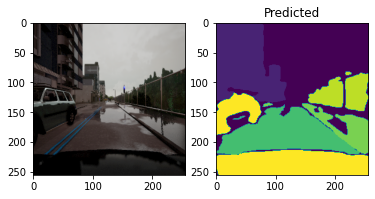

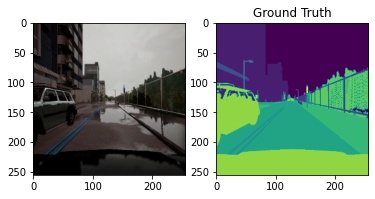

In [18]:
%%time
test = images[0]
getshape=test.shape
pred = model.predict(test.reshape(1,getshape[0],getshape[1],getshape[2]))

print(pred.shape)        
newimg = np.zeros((256,256))
print(pred)
for i in range(13):
    for j in range(256):
        for k in range(256):
            if pred[0,j,k,i] > 0.5:
                newimg[j,k] = i

plotter(test,newimg)
plt.title("Predicted")

plotter(test,annotations[0])
plt.title("Ground Truth")

In [19]:
RGB_dir='/content/drive/MyDrive/Colab Notebooks/rwth_kitti_semantics_dataset/images'
Label_dir='/content/drive/MyDrive/Colab Notebooks/rwth_kitti_semantics_dataset/labels_new'
images = list(sorted([ os.path.join(RGB_dir, fname) for fname in os.listdir(RGB_dir) ]))
segmentations = list(sorted([ os.path.join(Label_dir, fname) for fname in os.listdir(Label_dir)]))

In [20]:
test=[]
label=[]
for i in range(208):
    img2,mask2= cv2.imread(images[i]),cv2.imread(segmentations[i])[:,:,2]
    img2=cv2.resize(img2,(256,256)) 
    mask2=cv2.resize(mask2,(256,256)) 
    test.append(img2)
    label.append(mask2)
test=np.array(test)
label=np.array(label)

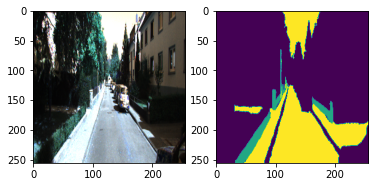

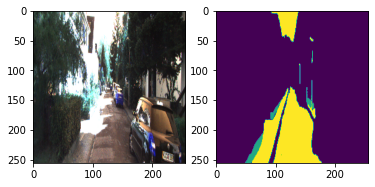

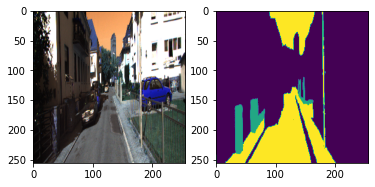

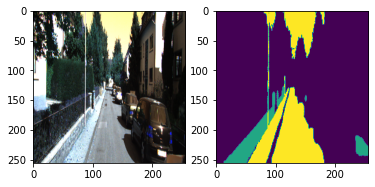

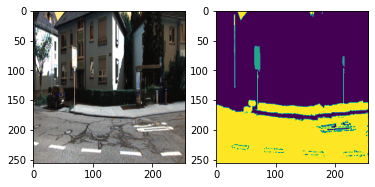

In [21]:
for i in range(5,10):
    plotter(test[i],label[i])

In [26]:
score = model.evaluate(test,label,verbose=0)
print('Test loss:', score[0])
print('Test accuracy:' ,score[1])

Test loss: 0.58913857004644330
Test accuracy: 0.85563964433646443


## Saving Model

In [23]:
!mkdir -p saved_model
model.save("/content/drive/MyDrive/Colab Notebooks/DEEP LAB MODEL/deeplabv3plus")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/DEEP LAB MODEL/deeplabv3plus/assets


In [24]:
model.save("/content/drive/MyDrive/Colab Notebooks/DEEP LAB MODEL/deeplabv3plus.h5")